In [1]:
# Always reload libraries
%load_ext autoreload
%autoreload 1
# Custom utils imports
%aimport my_utils.data_utils
%aimport my_utils.helper_functions
%aimport my_utils.training_utils
%aimport my_utils.param_utils
%aimport my_utils.model_classes
%aimport my_utils.prediction_utils
%aimport my_utils.plotting_utils
%aimport my_utils.save_and_load_utils
# Model-specific imports
%aimport my_utils.ann_training_utils
%aimport my_utils.skl_training_utils

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
import torch

# Import custom utils
from my_utils.data_utils import *
from my_utils.plotting_utils import *
from my_utils.save_and_load_utils import *
from my_utils.helper_functions import *
from my_utils.training_utils import *
from my_utils.param_utils import *
from my_utils.model_classes import *
from my_utils.prediction_utils import *
# Model-specific imports
from my_utils.ann_training_utils import *
from my_utils.skl_training_utils import *

## Set Parameters

In [3]:
model_config_id = 'mean_and_error_curves'
architecture = 'ANN' # ANN, RF, SVR

# Saving model and results
save_model_and_results = True
overwrite_existing_filename = False
filename_base = 'ann-behaviour-analysis-2' # What to save file as

In [4]:
# TEMPLATE: PARAM CONFIG X (DD/MM/YY) - Description
common_params = {
    'binning_params': {
        'curve_length_before_binning': 1000, # Number of points for uniform binning (default=1000) (if None, then strain_delta is used)
        'strain_delta': None, # Strain increment for uniform binning (default=0.0005) (if None, then curve_length_before_binning is used)
        'density': 0.6, # [0,1) where 0->1 = Uniform -> Gaussian (default=0.9)
        'location': 0.09, # (0,1) = left->right (default=0.07)
        'spread': 0.05, # [0,inf) = tight->wide (default=0.1)
        'verbose': False
    },
    'use_validation_set': True,
    # 'testIDs_of_test_data': [0, 2, 4, 6],
    # 'validation_TestIDs': [1, 3, 5],
    # 'additional_labels': ['Void_Fraction'],
    # 'additional_labels': ['Density'],
    # 'additional_labels': ['Aspect_Ratio'],
    # 'additional_labels': ['Parallelism'],
    # 'additional_labels': ['Void_Fraction','Density'],
    # 'additional_labels': ['Parallelism', 'Aspect_Ratio', 'Void_Fraction', 'Density'],
    # 'use_derivative_features': False,
    'seed': 0
}

if architecture == 'ANN':
    model_params = {
        'hyper_grid': {
            # 'candidate_hidden_configs': [[32], [128, 64], [32, 128, 128]],
            # 'candidate_hidden_configs': [[128, 64]],
            # 'candidate_hidden_configs': [[64],[32]],
            # 'candidate_hidden_configs': [[64], [128,256], [128,128,32]],
            'candidate_hidden_configs': [[64], [32], [128], [128,256], [64,32]],
            # 'dropout_rate': [0, 0.05],
            # 'weight_decay': [0, 1e-6]
        },
    }
elif architecture == 'RF':
    model_params = {
        'hyper_grid': {
            'n_estimators': [100],
            'max_depth': [None, 100],
            'min_samples_split': [2, 8], # Minimum number of samples needed in a node before it can be considered for splitting (higher minimum -> prevents overfitting)
            'min_samples_leaf': [2, 8], # Minimum number of samples required in a leaf node (higher minimum -> prevents overfitting)
        }
    }
elif architecture == 'SVR':
    model_params = {
        'hyper_grid': {
            'kernel': ['rbf'], # Kernel type
            # 'kernel': ['poly'], # Kernel type
            # 'degree': [5, 6],
            # 'gamma': [1, 5, 10], # Kernel coefficient for 'rbf', 'poly' and 'sigmoid'
            # 'gamma': ['scale'], # Kernel coefficient for 'rbf', 'poly' and 'sigmoid'
            # 'C': [1, 5],
            # 'epsilon': [0.005, 0.01],
            'gamma': [1, 5, 10],
            'C': [1, 5, 10],
            'epsilon': [0.005, 0.01],
        }
    }


## Setup

In [5]:
# Keep track of warnings
warnings_dict = {}
# Populate parameters
params, warnings_dict = get_parameters(common_params, model_params, model_config_id, architecture, warnings_dict, verbose=False)
# Set seed for reproducibility
seed = params['seed']
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)  # if using CUDA

No warnings
Model config ID mean_and_error_curves: Mean and error data point -> Mean and error data point
Omitted labels: ['Parallelism', 'Void_Fraction', 'Density', 'Aspect_Ratio']
    binning_params:
        curve_length_before_binning: 1000
        strain_delta: None
        density: 0.6
        location: 0.09
        spread: 0.05
        verbose: False
    use_validation_set: True
    seed: 0
    hyper_grid:
        candidate_hidden_configs: [[64], [32], [128], [128, 256], [64, 32]]


## Data Pre-processing

In [6]:
data_df, num_tests = preprocess_data(params)

Varying parameter: Volume_Fraction
Number of unique tests: 7
Min number of repeats: 3
Max number of repeats: 5
Input labels: ['Volume_Fraction', 'EngStrain']
Output labels: ['EngStress']


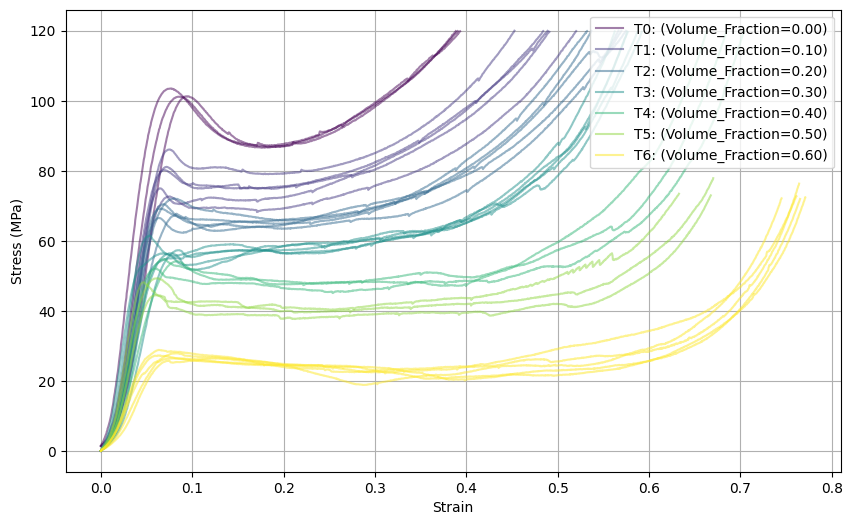

In [7]:
TestID_list = None
# TestID_list = [4] # list of curve indices to plot [0-6]
plot_curves(data_df, params, TestID_list=TestID_list, legend_type='test', raw_curves=True)

In [8]:
# Split and normalise
data_df_train_before_normalisation, data_df_test_before_normalisation, params, warnings_dict = train_test_split(
    data_df,
    params,
    warnings_dict=warnings_dict)

data_df_train, data_df_test, _, params = normalise_data(
    data_df_train_before_normalisation, 
    data_df_test_before_normalisation, 
    params,
    do_not_normalise=False)

all curves same length: False
Curve length range: 1141 1141
testIDs_of_test_data: [1, 3, 5]
all_labels: ['Volume_Fraction', 'EngStrain', 'EngStress_mean', 'EngStress_error']
probabilistic_output: True
average_all_curves: False
Binning parameters:
    curve_length_before_binning: 1000
    strain_delta: None
    density: 0.6
    location: 0.09
    spread: 0.05
    verbose: False


## Data Visualisation

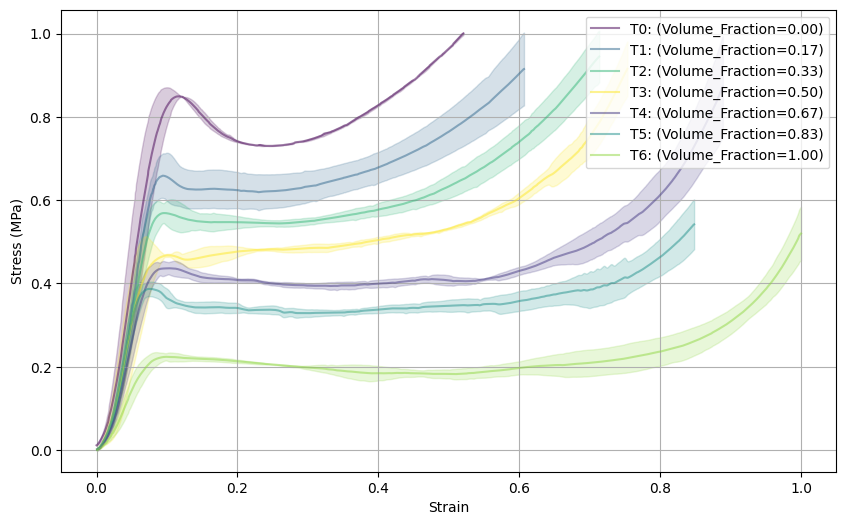

In [10]:
data_df_concat = pd.concat([data_df_train, data_df_test])
plot_curves(data_df_concat, params, legend_type='test', export_to_csv=True)

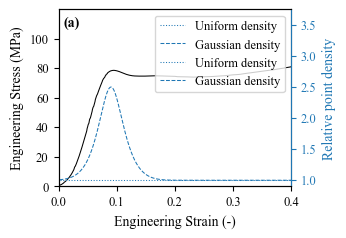

In [13]:
testID_plot = 1
plot_strain_histogram(data_df_concat, params, testID_plot)

array([[<Axes: title={'center': 'TestID'}>,
        <Axes: title={'center': 'RepeatID'}>],
       [<Axes: title={'center': 'Volume_Fraction'}>,
        <Axes: title={'center': 'EngStrain'}>],
       [<Axes: title={'center': 'EngStress_mean'}>,
        <Axes: title={'center': 'EngStress_error'}>]], dtype=object)

<Figure size 1000x600 with 0 Axes>

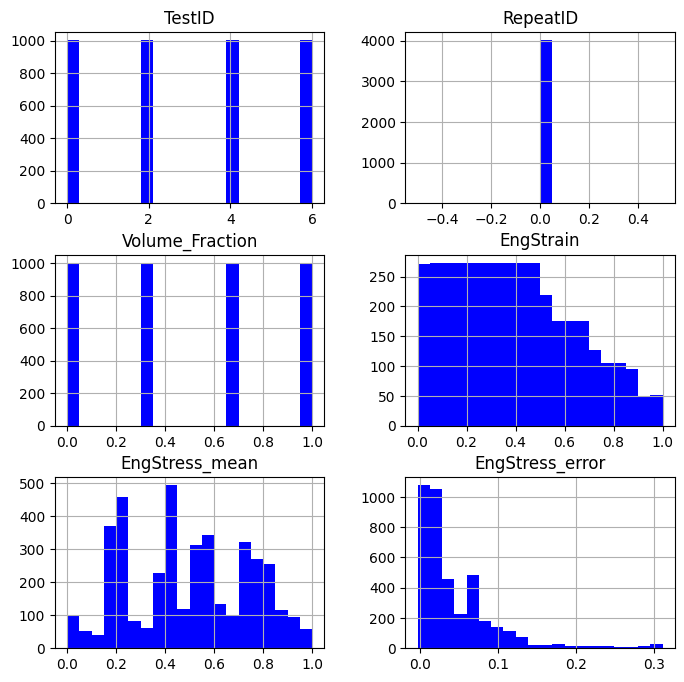

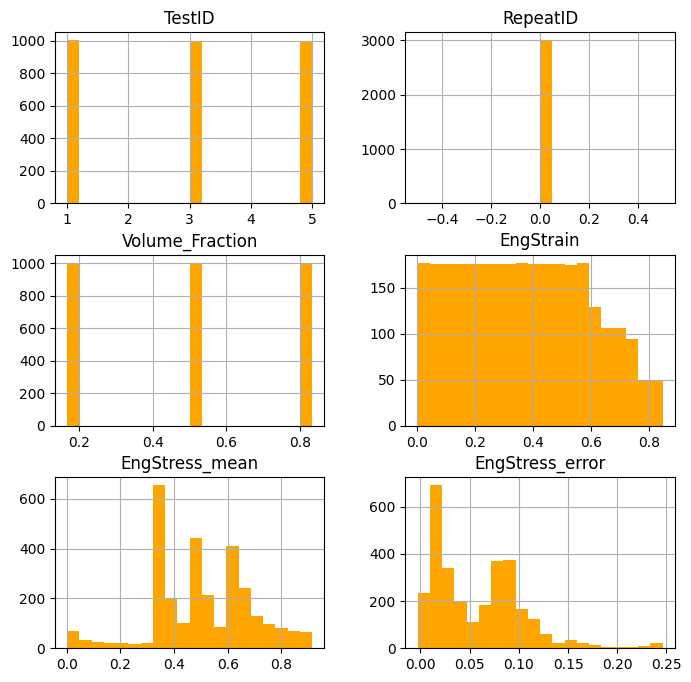

In [817]:
# Visualise in histograms
plt.figure(figsize=(10, 6))
data_df_train.hist(bins=20, figsize=(8, 8), color='blue')
data_df_test.hist(bins=20, figsize=(8, 8), color='orange')

## Model Definition

In [ ]:
model_class, device = get_model_class_and_device(architecture)

# Evaluation on Validation Sets

### Check for Warnings

In [821]:
# Print warnings
print_warnings(warnings_dict)

No warnings


### Train with Validation Sets

In [822]:
# df_valiation_results = dataframe of mean validation error vs config string
# config_dict = dictionary that relates config string to the actual hyperparameters
df_validation_results, config_dict, best_config, params, warnings_dict = train_with_validation(
    data_df_train, 
    params,
    architecture,
    warnings_dict, 
    device,
    model_class,
    verbose=False)

--------------- Validation set TestID: 0 (Set 1/4) ---------------
Batch size ratio: 0.13
Total number of parameter combinations: 5
Trained model 1/5 with {'candidate_hidden_configs': [64], 'dropout_rate': 0, 'weight_decay': 0} (test loss: 8.14e-03)
Trained model 2/5 with {'candidate_hidden_configs': [32], 'dropout_rate': 0, 'weight_decay': 0} (test loss: 6.03e-03)
Trained model 3/5 with {'candidate_hidden_configs': [128], 'dropout_rate': 0, 'weight_decay': 0} (test loss: 8.17e-03)
Trained model 4/5 with {'candidate_hidden_configs': [128, 256], 'dropout_rate': 0, 'weight_decay': 0} (test loss: 2.00e-02)
Trained model 5/5 with {'candidate_hidden_configs': [64, 32], 'dropout_rate': 0, 'weight_decay': 0} (test loss: 1.17e-02)
--------------- Validation set TestID: 2 (Set 2/4) ---------------
Batch size ratio: 0.13
Total number of parameter combinations: 5
Trained model 1/5 with {'candidate_hidden_configs': [64], 'dropout_rate': 0, 'weight_decay': 0} (test loss: 2.05e-03)
Trained model 2/5

### Validation Training Results

In [823]:
print_training_results(params, df_validation_results, 'validation_results')

================================ VALIDATION TRAINING RESULTS =================================
╒═════════════════════╤═══════════════════════════╤═════════════════════════════╕
│ hyperparam_config   │ mean_validation_MSE [-]   │   mean_validation_RMS [MPa] │
╞═════════════════════╪═══════════════════════════╪═════════════════════════════╡
│ 32-0-0              │ 3.73x10^-03               │                        7.23 │
├─────────────────────┼───────────────────────────┼─────────────────────────────┤
│ 128-0-0             │ 4.79x10^-03               │                        8.19 │
├─────────────────────┼───────────────────────────┼─────────────────────────────┤
│ 64-0-0              │ 8.82x10^-03               │                       11.11 │
├─────────────────────┼───────────────────────────┼─────────────────────────────┤
│ 128-256-0-0         │ 1.19x10^-02               │                       12.91 │
├─────────────────────┼───────────────────────────┼─────────────────────────────┤
│ 6

### Retrain Best Config and Plot Predicted Curves

Retraining model on selected validation set (index=1)
Batch size ratio: 0.13
Total number of parameter combinations: 1
Trained model 1/1 with {'candidate_hidden_configs': [32], 'dropout_rate': 0, 'weight_decay': 0} (test loss: 1.73e-03)
Batch size ratio: 0.13
------------------ ANN Predictions ------------------
Test loss: 1.73e-03
Train loss: 8.27e-04


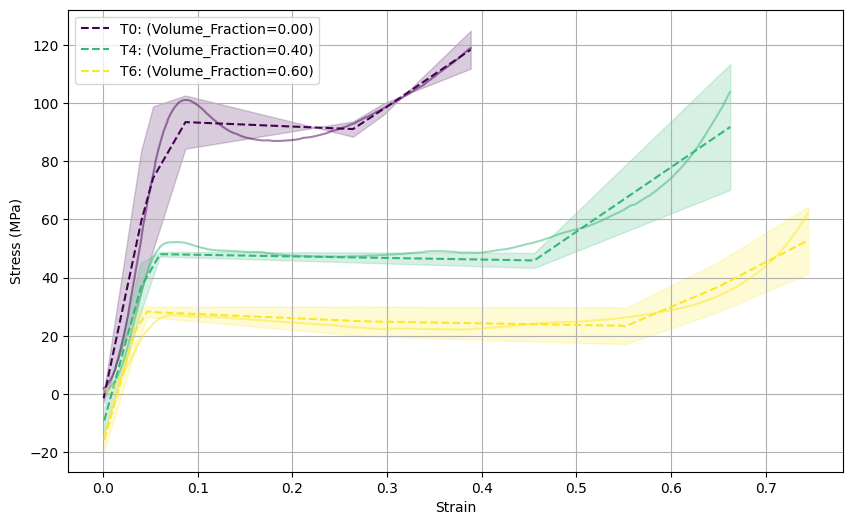

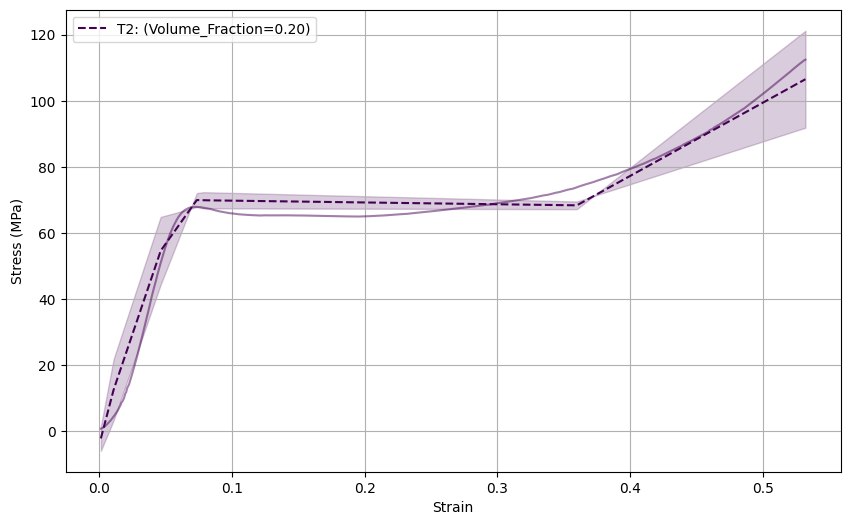

In [825]:
validation_set_index = 1 # Pick which validation set to use (not the TestID, the index)
export_to_csv = False # True=test set predictions are exported to csv

if params['use_validation_set']:
    best_results_validation, best_model_validation, df_train_train, df_validation, warnings_dict = retrain_best_config(
        data_df_train,
        device,
        architecture,
        params,
        warnings_dict,
        model_class,
        best_config,
        validation_set_index=validation_set_index)

    data_df_validation_results, params, warnings_dict = get_predictions_and_plot(
        df_train_train, 
        df_validation,
        best_model_validation,
        architecture, 
        device, 
        params, 
        warnings_dict,
        denormalise=True,
        export_to_csv=export_to_csv)
else:
    data_df_validation_results = None

### Additional Analysis

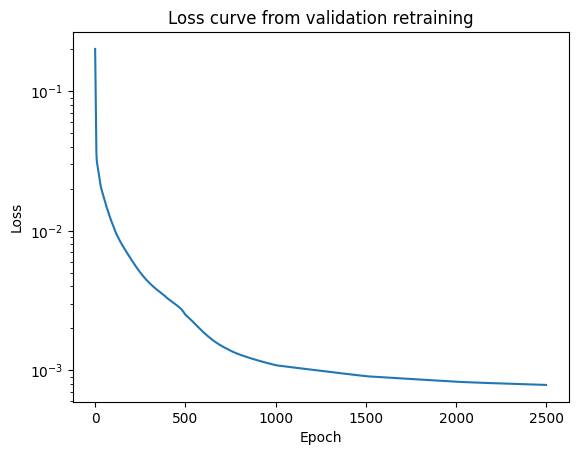

In [827]:
# plot loss curve
if architecture == 'ANN':
    # Plot loss curve
    plt.figure()
    losses_train_label = params['new_best_results_column_names']['losses_train']
    losses_train = best_results_validation[losses_train_label].iloc[0]
    plt.semilogy(losses_train)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss curve from validation retraining')

    # Plot num params vs test loss
    # plot_num_params_vs_test_loss(all_results)
else:
    print('No loss curve for other models (no gradient descent) and no num params.')

# Evaluation on Test Set

> ⚠️ DO NOT TUNE HYPERPARAMETERS BASED ON RESULTS BELOW THIS POINT ⚠️

 - If ```use_validation_sets=False```: ```best_config``` is None and ```best_model``` is found by grid search over whole train set
 - If ```use_validation_sets=True```: ```best_config``` is ***not*** None (found from validation) and is now trained on whole train set.

### Check for Warnings

In [828]:
# Print warnings
print_warnings(warnings_dict)

No warnings


### Train on Train Set

In [829]:
df_all_results, df_best_results, best_model, all_models, warnings_dict = train_with_grid_search(
    data_df_train,
    data_df_test, 
    params, 
    warnings_dict,
    device, 
    model_class,
    architecture,
    best_config=best_config,
    process_results=True,
    verbose=False)

Batch size ratio: 0.10
Total number of parameter combinations: 1
Trained model 1/1 with {'candidate_hidden_configs': [32], 'dropout_rate': 0, 'weight_decay': 0} (test loss: 1.86e-03)


### Final Training Results

In [830]:
print_training_results(params, df_validation_results, 'validation_results')
print_training_results(params, df_all_results, 'all_results')
print_training_results(params, df_best_results, 'best_results')

================================ VALIDATION TRAINING RESULTS =================================
╒═════════════════════╤═══════════════════════════╤═════════════════════════════╕
│ hyperparam_config   │ mean_validation_MSE [-]   │   mean_validation_RMS [MPa] │
╞═════════════════════╪═══════════════════════════╪═════════════════════════════╡
│ 32-0-0              │ 3.73x10^-03               │                        7.23 │
├─────────────────────┼───────────────────────────┼─────────────────────────────┤
│ 128-0-0             │ 4.79x10^-03               │                        8.19 │
├─────────────────────┼───────────────────────────┼─────────────────────────────┤
│ 64-0-0              │ 8.82x10^-03               │                       11.11 │
├─────────────────────┼───────────────────────────┼─────────────────────────────┤
│ 128-256-0-0         │ 1.19x10^-02               │                       12.91 │
├─────────────────────┼───────────────────────────┼─────────────────────────────┤
│ 6

### Plot Predicted Curves

Batch size ratio: 0.10
------------------ ANN Predictions ------------------
Test loss: 1.86e-03
Train loss: 3.35e-04


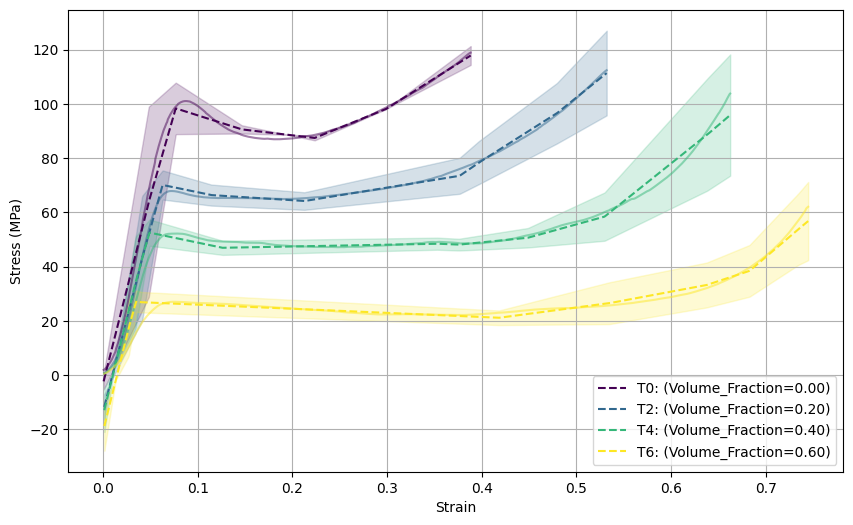

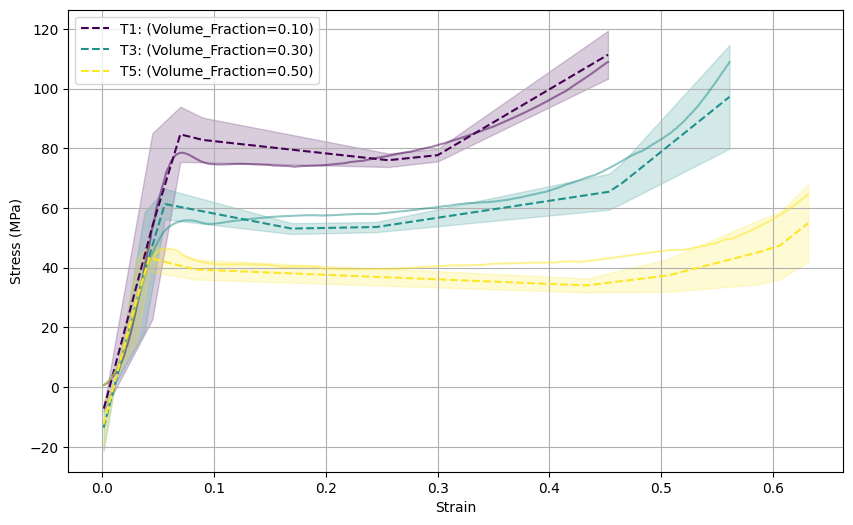

In [831]:
data_df_final_results, params, warnings_dict = get_predictions_and_plot(
    data_df_train, 
    data_df_test,
    best_model,
    architecture, 
    device, 
    params, 
    warnings_dict,
    denormalise=True)

### Additional Analysis

Final train loss: 3.34e-04
Final train loss (RMS_denorm): 2.16e+00


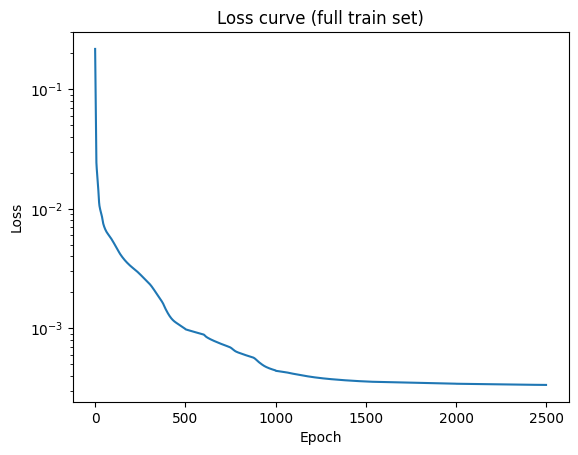

In [832]:
# Print train losses
losses_train_label = params['new_best_results_column_names']['losses_train']
losses_train = df_best_results[losses_train_label].iloc[0]
print_train_loss_from_losses(losses_train, params)

if architecture == 'ANN':
    # Plot loss curve
    plt.figure()
    plt.semilogy(losses_train)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss curve (full train set)')
    
    # Plot num params vs test loss
    # plot_num_params_vs_test_loss(all_results)
else:
    print('No loss curve for other models (no gradient descent) and no num params.')

# Saving Model and Results

### Check Warnings

In [833]:
print_warnings(warnings_dict)

No warnings


### Save Model

In [ ]:
if save_model_and_results:
    df_results_dict = {
        'validation_results': df_validation_results,
        'all_results': df_all_results,
        'best_results': df_best_results,
    }
    save_and_load_model_and_results(mode='save', 
                                    filename_base=filename_base,
                                    architecture=architecture,
                                    version=2,
                                    model=best_model,
                                    params=params,
                                    warnings_dict=warnings_dict,
                                    df_results_dict=df_results_dict,
                                    data_df_final_results=data_df_final_results,
                                    data_df_validation_results=data_df_validation_results,
                                    overwrite_existing_filename=overwrite_existing_filename,
                                    model_config_id=model_config_id)

### Load Model

In [ ]:
# Load model, and plot predictions
date = None
model_config_id = 'mean_and_error_curves'

# Example:
# date = '04-14'
# architecture = 'ANN'
# filename_base = 'ann-final-eval-extrapolation'


data, model = save_and_load_model_and_results(mode='load', 
                                              filename_base=filename_base,
                                              architecture=architecture,
                                              version=2,
                                              model_config_id=model_config_id,
                                              date=date)

# Plot train set predictions
plot_curves(data['data_df_final_results'], 
            data['params'], 
            TestID_list=data['params']['testIDs_of_train_data'], 
            plot_predictions=True,
            legend_type='test',
            export_to_csv=False)
# Plot test set predictions
plot_curves(data['data_df_final_results'], 
            data['params'], 
            TestID_list=data['params']['testIDs_of_test_data'], 
            plot_predictions=True,
            legend_type='test',
            export_to_csv=False)

# print(f'Validation Time Taken: {data['params']['validation_training_time']:.2f} seconds')
print_training_results(data['params'], data['df_validation_results'], 'validation_results')
# print_training_results(params, data['df_all_results'], 'all_results')
print_training_results(data['params'], data['df_best_results'], 'best_results')

# Print RMSE* for just mean stress
print_mean_stress_RMSE_from_results(data, error_label='train_error')

_, _ = print_yield_strength(data=data, strain_threshold=0.1)